This notebook contains analysis on 2018 data

In [65]:
#helper function for confidence interval for pearsonr (sourced from github.com/zhiyzuo/pearsonr_ci.py):
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [3]:
#Calculate scores for GAD-7 response data
def gad(responses):
    score_dict={'Not at all':0,'Several Days':1,'More than half the days':2,'Nearly every day':3}
    score=0
    for i in range(len(responses)):
        score+=score_dict[responses['Q'+str(i)]]
    return score

In [4]:
#Function to calculate PANAS scores
def panas(responses):
    pos=[0,2,4,8,9,11,13,15,16,18]
    neg=[1,3,5,6,7,10,12,14,17,19]
    pas=0
    nas=0
    score_dict={' Very Slightly or Not at All ':1, 'A Little':2, 'Moderately':3, 'Quite a bit': 4, 'Extremely':5}
    for i in range(len(responses)):
        if i in pos:
            pas+=score_dict[responses['Q'+str(i)]]
        else:
            nas+=score_dict[responses['Q'+str(i)]]
    return pas, nas
            

In [5]:
#Function to calculate LOT-R scores
def lotr(responses):
    score=0
    pos=[0,3,9]
    neg=[1,6,8]
    score_dict={'I strongly disagree':0,'I disagree':1,'I neither agree nor disagree':2,'I agree':3,'I strongly agree':4}
    rev_score_dict={'I strongly disagree':4,'I disagree':3,'I neither agree nor disagree':2,'I agree':1,'I strongly agree':0}
    for i in range(len(responses)):
        if i in pos:
            score+=score_dict[responses['Q'+str(i)]]
        elif i in neg:
            score+=rev_score_dict[responses['Q'+str(i)]]
    return score

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
#read in only 2018 data
f=pd.read_json('clean_data.json','r')
no_ind=44

#Populate relevant arrays with responses for questions associated with each statement

before_resp=[[] for i in range(len(f))]
after_resp=[[] for i in range(len(f))]
confidence=[[] for i in range(no_ind)]
prior_knowledge=[[] for i in range(no_ind)]
no_for=[[] for i in range(len(f))]
no_against=[[] for i in range(len(f))]
no_blanc=[[] for i in range(len(f))]
no_noir=[[] for i in range(len(f))]
no_gris=[[] for i in range(len(f))]
fear_score=[[] for i in range(len(f))]
emo_score=[[] for i in range(len(f))]
hope_score=[[] for i in range(len(f))]
rel_score=[[] for i in range(len(f))]
time_dict_list=[[dict() for x in range(16)] for y in range(no_ind)]
noir_bias=[]
blanc_bias=[]
gris_bias=[]
panas_responses=[]
gad_responses=[]
lotr_responses=[]
for i in range(no_ind):
    jj=0
    for j in range(5,100):
        a=f.iloc[i][j]
        if a['internal_node_id'].endswith('-4.0'):
            if a['statementResponse']==100:
                after_resp[i].append(99)
            else:
                after_resp[i].append(a['statementResponse'])
        elif a['internal_node_id'].endswith('0.0'):
            if a['statementResponse']==100:
                before_resp[i].append(99)
            else:
                before_resp[i].append(a['statementResponse'])
        elif a['internal_node_id'].endswith('-1.0'):
            confidence[i].append(a['responses'][0])
            prior_knowledge[i].append(a['responses'][1])
            emo_score[i].append(a['responses'][2])
            rel_score[i].append(a['responses'][3])
        elif a['internal_node_id'].endswith('2.0'):
            hope_score[i].append(a['responses'][0])
            fear_score[i].append(a['responses'][1])
        elif a['internal_node_id'].endswith('3.0'):
            no_for[i].append(len(a['alphaNews'])+a['firstForAgainst'].count('for'))
            no_against[i].append(len(a['premierNews'])+a['firstForAgainst'].count('against'))
            no_blanc[i].append(len(a['alphaNews']))
            no_noir[i].append(len(a['premierNews']))
            no_gris[i].append(len(a['firstNews']))
            for item in a['alphaNews']:
                time_dict_list[i][jj][str(item)]='for'
            for item in a['premierNews']:
                time_dict_list[i][jj][str(item)]='against'
            for k in range(len(a['firstNews'])):
                time_dict_list[i][jj][str(a['firstNews'][k])] = a['firstForAgainst'][k]
            jj+=1
    if i<8:
        gad_resp=f.iloc[i][103]
        lotr_resp=f.iloc[i][104]
        panas_resp=f.iloc[i][105]
        panas_responses.append(panas_resp['responses'])
        gad_responses.append(gad_resp['responses'])
        lotr_responses.append(lotr_resp['responses'])
    else:
        noir_bias.append(100-f.iloc[i][101]['premierBias'])
        gris_bias.append(100-f.iloc[i][101]['firstBias'])
        blanc_bias.append(100-f.iloc[i][101]['alphaBias'])
        gad_resp=f.iloc[i][104]
        lotr_resp=f.iloc[i][105]
        panas_resp=f.iloc[i][106]
        panas_responses.append(panas_resp['responses'])
        gad_responses.append(gad_resp['responses'])
        lotr_responses.append(lotr_resp['responses'])
emo_score=np.asarray(emo_score)
fear_score=np.asarray(fear_score)
rel_score=np.asarray(rel_score)
hope_score=np.asarray(hope_score)

News Bias

In [67]:
print(np.mean(blanc_bias),np.mean(noir_bias),np.mean(gris_bias))
stats.f_oneway(blanc_bias,noir_bias,gris_bias)

50.833333333333336 55.638888888888886 42.361111111111114


F_onewayResult(statistic=2.0915101250179395, pvalue=0.12861607635122965)

Acquisition Bias

704
F_onewayResult(statistic=9.467637795452397, pvalue=8.065024200194857e-05)


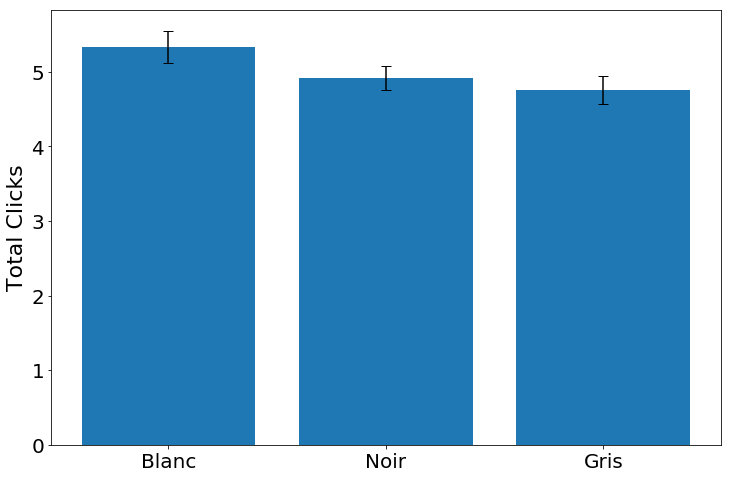

In [68]:
#Plot mean number of clicks and standard error bars for each news source
import itertools
from scipy import stats
blanc = np.ndarray.flatten(np.asarray(no_blanc))
noir=np.ndarray.flatten(np.asarray(no_noir))
gris=np.ndarray.flatten(np.asarray(no_gris))

means=[np.mean(blanc),np.mean(noir),np.mean(gris)]
sems=[np.std(blanc),np.std(noir),np.std(gris)]/np.sqrt(44)
err=np.ones((2,3))
err[:,0]=abs(means[0]-stats.norm.interval(0.95,loc=np.mean(blanc),scale=np.std(blanc)/np.sqrt(len(blanc))))
err[:,1]=abs(means[1]-stats.norm.interval(0.95,loc=np.mean(noir),scale=np.std(noir)/np.sqrt(len(noir))))
err[:,2]=abs(means[2]-stats.norm.interval(0.95,loc=np.mean(gris),scale=np.std(gris)/np.sqrt(len(gris))))
#print(err)
objects=['Blanc','Noir','Gris']
y = np.arange(len(objects))
plt.figure(figsize=(12,8))
plt.bar(y,means,yerr=err,capsize=5)
plt.xticks(y,objects)
plt.ylabel('Total Clicks')

print(stats.f_oneway(noir, gris, blanc))

Then do analysis on distribution of responses:

In [69]:
before_arr=[]
after_arr=[]
for i in range(no_ind):
    before_arr=before_arr+before_resp[i]
    after_arr=after_arr+after_resp[i]

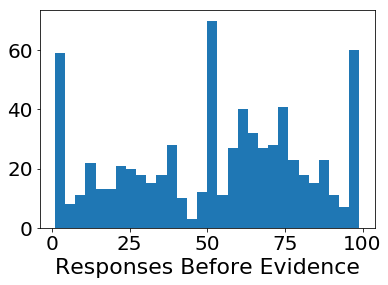

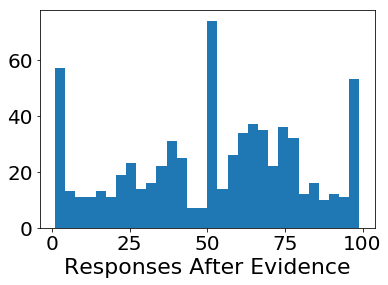

In [70]:
plt.figure()
plt.hist(before_arr,30)
plt.xlabel('Responses Before Evidence')
plt.show()
plt.hist(after_arr,30)
plt.xlabel('Responses After Evidence')
plt.show()
plt.savefig('response_dist.png')

Positive and negative beliefs

In [71]:
statement_sent=[-1,-1,1,1,-1,1,-1,-1,1,1,1,1,-1,1,1,1]
pos_belief=np.zeros((no_ind,16))
for i in range(no_ind):
    for j in range(len(before_resp[i])):
        if statement_sent[j]==-1 and before_resp[i][j]<50:
            pos_belief[i][j]=1
        elif statement_sent[j]==1 and before_resp[i][j]>50:
            pos_belief[i][j]=1
p_pos=np.mean(pos_belief,axis=1)
q_pos=np.mean(pos_belief,axis=0)

Analysis of updates by question

In [75]:
from scipy import stats
before=np.asarray(before_resp)
after=np.asarray(after_resp)
knowledge=np.asarray(prior_knowledge)
conf=np.asarray(confidence)
bef_tot=np.ndarray.flatten(before)
aft_tot=np.ndarray.flatten(after)
knowledge_tot=np.ndarray.flatten(knowledge)
conf_tot=np.ndarray.flatten(conf)
update=before-after
no_for=np.asarray(no_for)
no_against=np.asarray(no_against)
acq_b=np.mean(no_for-no_against,axis=0)
q_update=np.mean(abs(update),axis=0)
p_update=np.mean(abs(update),axis=1)
print(stats.pearsonr(knowledge_tot,conf_tot))
print(stats.pearsonr(abs(50-bef_tot),conf_tot))
print(pearsonr_ci(q_update,np.mean(knowledge,axis=0)))
print(pearsonr_ci(q_update,np.mean(confidence,axis=0)))

(0.6122915688400493, 1.1713176620578121e-73)
(0.6542705184020625, 3.0861201904843386e-87)
(-0.7381462656274177, 0.0010951696941136672, -0.9033229746692958, -0.3823404784379693)
(-0.6804924305394182, 0.003716869186220212, -0.8795161101375182, -0.2788497304187104)


Calculate questionnaire scores:

In [76]:
import ast
gad_scores=[]
pas_scores=[]
nas_scores=[]
lotr_scores=[]
for i in range(len(panas_responses)):
    pas_scores.append(panas(ast.literal_eval(panas_responses[i]))[0])
    nas_scores.append(panas(ast.literal_eval(panas_responses[i]))[1])
for i in range(len(gad_responses)):
    gad_scores.append(gad(ast.literal_eval(gad_responses[i])))
for i in range(len(lotr_responses)):
    lotr_scores.append(lotr(ast.literal_eval(lotr_responses[i])))

In [77]:
print('Mean GAD score= '+str(np.mean(gad_scores))+', Standard Deviation '+str(np.std(gad_scores)))
print('Mean Pos. Affect score= '+str(np.mean(pas_scores))+', Standard Deviation '+str(np.std(pas_scores)))
print('Mean Neg. Affect score= '+str(np.mean(nas_scores))+', Standard Deviation '+str(np.std(nas_scores)))
print('Mean LOT-R score= '+str(np.mean(lotr_scores))+', Standard Deviation '+str(np.std(lotr_scores)))


Mean GAD score= 4.590909090909091, Standard Deviation 4.923589700329434
Mean Pos. Affect score= 28.295454545454547, Standard Deviation 8.640758451176046
Mean Neg. Affect score= 17.545454545454547, Standard Deviation 8.494529109573316
Mean LOT-R score= 12.340909090909092, Standard Deviation 5.291258579522635


In [78]:
print(pearsonr_ci(pas_scores,lotr_scores))
print(pearsonr_ci(pas_scores,nas_scores))
print(pearsonr_ci(pas_scores,gad_scores))
print(pearsonr_ci(lotr_scores,gad_scores))
print(pearsonr_ci(lotr_scores,nas_scores))
print(pearsonr_ci(gad_scores,nas_scores))

(0.6922340232265244, 1.9391839939321222e-07, 0.49761985387029595, 0.8204940854080324)
(-0.570693474593025, 5.233986153870814e-05, -0.7418789997840173, -0.3296679901698586)
(-0.5489999150448467, 0.00011387023885477365, -0.7273340705301878, -0.3012135227735953)
(-0.6358472052585129, 3.5188334182343617e-06, -0.7846153092621126, -0.41784335659628274)
(-0.5856333112404685, 2.9660867400911904e-05, -0.7518029411277551, -0.3495218743952073)
(0.8280552427558235, 4.075648168663511e-12, 0.704320285598071, 0.9029583416865734)


Model 1 Conf Bias Calculation

In [80]:
from scipy.optimize import least_squares
from scipy.stats import beta
import math

no_for_arr=np.asarray(no_for)
no_against_arr=np.asarray(no_against)
before=np.asarray(before_resp)
after=np.asarray(after_resp)
no_true=np.zeros((no_ind,16))
no_false=np.zeros((no_ind,16))

#define evidence arrays in terms of agreement with statements
for i in range(no_ind):
    for j in range(len(no_for_arr[i])):
        if before[i][j]>=50:
            no_true[i][j]=no_for_arr[i][j]
            no_false[i][j]=no_against_arr[i][j]
        else:
            no_true[i][j]=no_against_arr[i][j]
            no_false[i][j]=no_for_arr[i][j]

mode_new=np.zeros((no_ind,len(before[0])))
for i in range(len(before)):
    for j in range(len(before[i])):
        y=before[i][j]*0.01
        if y!=0.5:
            #estimate prior:
            def equations(p):
                a,b = p
                return ((a-1)/(a+b-2)-y,1/(confidence[i][j])-a*b/((a+b+1)*(a+b)**2))
            res = least_squares(equations, (5, 2), bounds = ((1, 1), (math.inf, math.inf)))
            a,b=res.x
            dist= beta(a,b)
            #define likelihood by evidence:
            likelihood=x**no_true[i][j]*(1-x)**(15-no_true[i][j])
            #posterior estimate
            mode_new[i][j]=(a+no_true[i][j]-1)/(a+b+15-2)

In [17]:
#conf bias calculation for Model 1:
after_opt=mode_new*100
confirm=np.zeros((len(mode_new),len(mode_new[0])))
for i in range(len(confirm)):
    for j in range(len(confirm[i])):
        if before[i][j]>50:
            confirm[i][j]=after[i][j]-after_opt[i][j]
        elif before[i][j]<50:
            confirm[i][j]=after_opt[i][j]-after[i][j]

(0.8274528401855423, 4.199925542268793e-178)

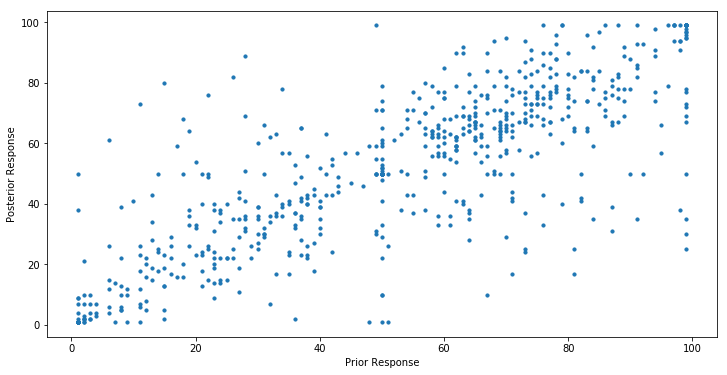

In [18]:
#Prior vs. Posterior Responses
plt.figure(figsize=(12,6))
plt.scatter(before_resp,after_resp,10)
plt.xlabel('Prior Response')
plt.ylabel('Posterior Response')
stats.pearsonr(np.concatenate(before_resp),np.concatenate(after_resp))

Ttest_1sampResult(statistic=16.91093854788738, pvalue=2.6146509492745255e-53)
12.658808963777384
1.4660277064710967


Text(0,0.5,'Number of Updates')

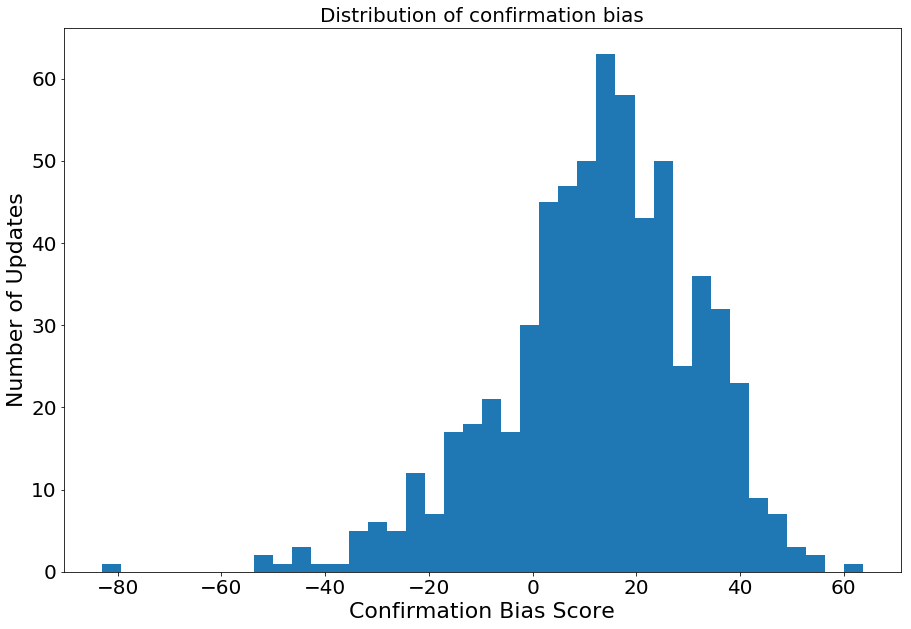

In [81]:
#Plot distribution of confirmation bias scores, omitting neutral beliefs
from scipy import stats
zero_ind=[]
for i in range(len(np.concatenate(confirm))):
    if np.ndarray.flatten(np.asarray(before_resp))[i]==50:
        zero_ind.append(i)
confirm_adj=np.delete(np.concatenate(confirm),zero_ind)
print(stats.ttest_1samp(confirm_adj,0))
print(np.mean(confirm_adj))
print(1.96*np.std(confirm_adj)/np.sqrt(len(confirm_adj)))
plt.figure(figsize=(15,10))
plt.rc('axes',labelsize=22)
plt.rc('font',size=20)
plt.rc('axes',titlesize=20)
plt.hist(confirm_adj,40)
plt.title('Distribution of confirmation bias')
plt.xlabel('Confirmation Bias Score')
plt.ylabel('Number of Updates')

Model 2 Individual Conf Bias Calculation

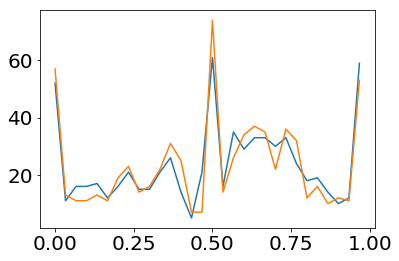

(0.4427075514710737, 0.002618922024761416)
0.015533831683163718


Ttest_1sampResult(statistic=0.20110869704131396, pvalue=0.841561873309555)

In [82]:
from scipy.optimize import least_squares
from scipy.stats import pearsonr
import math

mode_new=np.zeros((no_ind,16))
con_prob=np.zeros((no_ind,16))
alpha_arr=np.zeros((no_ind,16))
beta_arr=np.zeros((no_ind,16))
cost=[]
for i in range (no_ind):
    for j in range(len(before[i])):
        y=before[i][j]*0.01
        if y!=0.5:
            def equations(p):
                a,b = p
                return ((a-1)/(a+b-2)-y,1/confidence[i][j]-a*b/((a+b+1)*(a+b)**2))
            res = least_squares(equations, (5, 2), bounds = ((1, 1), (math.inf, math.inf)))
            a,b=res.x
            alpha_arr[i][j]=a
            beta_arr[i][j]=b

weight_conf=np.zeros(no_ind)
weight_disc=np.zeros(no_ind)
weight_evid=np.zeros(no_ind)
for i in range(no_ind):
    def equation(x):
        eqns=np.zeros(16)
        for j in range(16):
            if before[i][j]>=50:
                eqns[j]=(0.01*after[i][j]-(alpha_arr[i][j]+x[0]*x[1]*no_true[i][j]-1)
                         /(alpha_arr[i][j]+beta_arr[i][j]+x[0]*(x[1]*no_true[i][j] + x[2]*no_false[i][j])-2))
            elif before[i][j]<50:
                eqns[j]=(0.01*after[i][j]-(alpha_arr[i][j]+x[0]*x[2]*no_true[i][j]-1)
                         /(alpha_arr[i][j]+beta_arr[i][j]+x[0]*(x[2]*no_true[i][j] + x[1]*no_false[i][j])-2))
        return eqns
    res= least_squares(equation,[0.01,0.5,0.5],bounds=([0,0,0],[np.inf,1,1]))
    cost.append(res.cost)
    weight_conf[i]=res.x[1]
    weight_disc[i]=res.x[2]
    weight_evid[i]=res.x[0]
def sim_resp(i):
    sim=np.zeros(16)
    for j in range(16):
        if before[i][j]>=50:
            sim[j]=(alpha_arr[i][j]+res.x[0]*res.x[1]*no_true[i][j]-1)/(alpha_arr[i][j]+beta_arr[i][j]+res.x[0]*(res.x[1]*no_true[i][j] + res.x[2]*no_false[i][j])-2)
        elif before[i][j]<50:
            sim[j]=(alpha_arr[i][j]+res.x[0]*res.x[2]*no_true[i][j]-1)/(alpha_arr[i][j]+beta_arr[i][j]+res.x[0]*(res.x[2]*no_true[i][j] + res.x[1]*no_false[i][j])-2)
    return sim

model_resp=np.zeros((no_ind,16))
for i in range(no_ind):
    model_resp[i]=sim_resp(i)
y_1,bins_1=np.histogram(np.ndarray.flatten(model_resp),30)
plt.plot(bins_1[:len(bins_1)-1],y_1)
y_2,bins_2=np.histogram(np.ndarray.flatten(0.01*after),30)
plt.plot(bins_1[:len(bins_2)-1],y_2)
plt.show()
ll=[]
for i in range(no_ind):
    ll.append(cost[i])
#confirmation for participants, model 2
new_confirm=weight_conf-weight_disc

#confirmation for participants, model 1
ind_confirm=np.mean(confirm,axis=1)

print(stats.pearsonr(new_confirm,ind_confirm))
print(np.mean(new_confirm))

stats.ttest_1samp(new_confirm,0)
#print(ll)

In [21]:
BIC=[]
for i in range(no_ind):
    BIC.append(4*np.log(16)+16*np.log(ll[i]))

In [22]:
AIC=[]
k=4
for i in range(no_ind):
    AIC.append(2*k+16*np.log(ll[i]))

Model 2 Statement Conf Bias Calculation

(0.855168290035268, 2.4226395676832033e-05)
0.23496822717498816


Ttest_1sampResult(statistic=5.322348186424896, pvalue=8.534953958070682e-05)

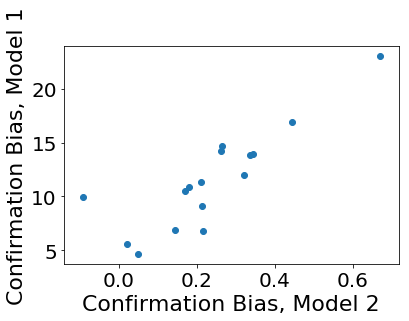

In [84]:
from scipy.optimize import least_squares
from scipy.stats import pearsonr
import math

mode_new=np.zeros((no_ind,16))
alpha_arr=np.zeros((no_ind,16))
beta_arr=np.zeros((no_ind,16))
for i in range (no_ind):
    for j in range(len(before[i])):
        y=before[i][j]*0.01
        if y!=0.5:
            #estimate priors for each statement and participant
            def equations(p):
                a,b = p
                return ((a-1)/(a+b-2)-y,1/confidence[i][j]-a*b/((a+b+1)*(a+b)**2))
            res = least_squares(equations, (5, 2), bounds = ((1, 1), (math.inf, math.inf)))
            a,b=res.x
            alpha_arr[i][j]=a
            beta_arr[i][j]=b
            
#arrays for weights to be fitted
weight_conf_q=np.zeros(16)
weight_disc_q=np.zeros(16)
weight_evid_q=np.zeros(16)
cost_arr=[]
for j in range(16):
    def equation(x):
        #fit responses to new mode defined by model with weights on conf and disc headlines:
        eqns=np.zeros(no_ind)
        for i in range(44):
            if before[i][j]>=50:
                eqns[i]=(0.01*after[i][j]-(alpha_arr[i][j]+x[0]*x[1]*no_true[i][j]-1)
                         /(alpha_arr[i][j]+beta_arr[i][j]+x[0]*(x[1]*no_true[i][j] + x[2]*no_false[i][j])-2))
            elif before[i][j]<50:
                eqns[i]=(0.01*after[i][j]-(alpha_arr[i][j]+x[0]*x[2]*no_true[i][j]-1)
                         /(alpha_arr[i][j]+beta_arr[i][j]+x[0]*(x[2]*no_true[i][j] + x[1]*no_false[i][j])-2))
        return eqns
    res= least_squares(equation,0.5*np.ones(3),bounds=([0,0,0],[np.inf,1,1]))
    cost_arr.append(res.cost)
    weight_conf_q[j]=res.x[1]
    weight_disc_q[j]=res.x[2]
    weight_evid_q[j]=res.x[0]
#comparisons with model 1
print(stats.pearsonr(weight_conf_q-weight_disc_q,np.mean(confirm,axis=0)))
new_confirm_q=weight_conf_q-weight_disc_q
plt.scatter(new_confirm_q, np.mean(confirm,axis=0))
plt.xlabel('Confirmation Bias, Model 2')
plt.ylabel('Confirmation Bias, Model 1')
print(np.mean(new_confirm_q))
stats.ttest_1samp(weight_conf_q-weight_disc_q,0)
#print(ll)

In [85]:
np.sum(new_confirm>0)

24

Reinforcement Learning Model

In [87]:
#define rewards array for each set of headlines
rewards=np.zeros((no_ind,16,15))
for i in range(no_ind):
    for j in range(16):
        k=0
        for key in sorted(time_dict_list[i][j].keys()):
            if time_dict_list[i][j][key]=='for':
                rewards[i][j][k]=1
            k+=1

Individual Bias

In [97]:
from scipy.optimize import least_squares
from scipy.special import logit,expit

#RL update:
def update(rho_ev,rho_c,rho_d,reward,V_0):
    V=V_0
    for i in range(len(reward)):
        if reward[i]==1:
            V= V + rho_ev*rho_c*(reward[i]-V)
        elif reward[i]==0:
            V= V + rho_ev*rho_d*(reward[i]-V)
    return V

#define value as belief in preferred hypothesis
value_array=np.zeros((no_ind,16))
after_array=np.zeros((no_ind,16))
for i in range(no_ind):
    for j in range(16):
        if before_resp[i][j]>=50:
            value_array[i][j]=before_resp[i][j]
            after_array[i][j]=after_resp[i][j]
        else:
            value_array[i][j]=100-before_resp[i][j]
            after_array[i][j]=100-after_resp[i][j]

value_array=0.01*value_array
confirm_rl=np.zeros(no_ind)
alpha_con=[]
alpha_dis=[]
beta=[]
ll_3=[]
for i in range(no_ind):
    #fit model updates to responses in data
    def equation(x):
        eqns=np.zeros(16)
        k=0
        for j in range(16):
            eqns[j]=(0.01*after_array[i][j]-update(x[0],x[1],x[2],rewards[i][j],value_array[i][j]))
            k+=1
        return eqns
    res= least_squares(equation,[0.01,0.5,0.5],bounds=([0,0,0],[1,1,1]))
    ll_3.append(res.cost)
    alpha_con.append(res.x[1])
    alpha_dis.append(res.x[2])
    beta.append(res.x[0])
    confirm_rl[i]=(res.x[1]-res.x[2])
    


In [98]:
BIC_2=[]
for i in range(no_ind):
    BIC_2.append(4*np.log(16)+16*np.log(ll_3[i]))

In [99]:
AIC_2=[]
k=4
for i in range(no_ind):
    AIC_2.append(2*k+16*np.log(ll_3[i]))

In [100]:
print(np.sum(np.array(BIC)-np.array(BIC_2)>0))

16


(0.598025446978195, 1.8120583417661003e-05)
22


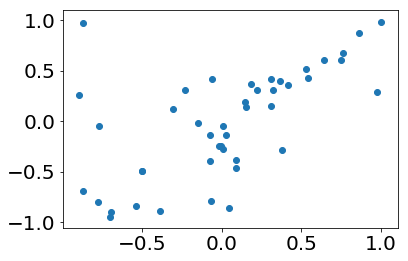

In [101]:
#correlation between models 2 and 3
plt.scatter(new_confirm,confirm_rl)
print(stats.pearsonr(new_confirm,confirm_rl))
print(np.sum(confirm_rl>0))

(0.5156694119898835, 0.0003404105765669259)


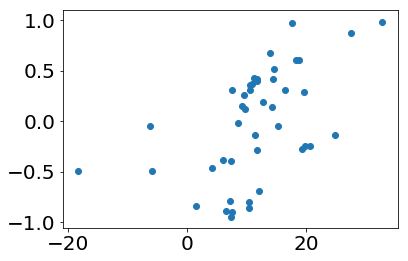

In [102]:
#correlation between model 1 and 3
plt.scatter(ind_confirm,confirm_rl)
print(stats.pearsonr(ind_confirm,confirm_rl))

RL Bias by Statement

In [103]:
from scipy.optimize import least_squares

#fit same model but for each question
confirm_rl_q=np.zeros(16)
alpha_con_q=[]
alpha_dis_q=[]
beta_q=[]
ll=[]
for j in range(16):
    def equation(x):
        eqns=np.zeros(no_ind)
        for i in range(no_ind):
            eqns[i]=(0.01*after_array[i][j]-update(x[0],x[1],x[2],rewards[i][j],value_array[i][j]))
        return eqns
    res= least_squares(equation,[0.01,0.5,0.5],bounds=([0,0,0],[1,1,1]))
    ll.append(res.cost)
    alpha_con_q.append(res.x[1])
    alpha_dis_q.append(res.x[2])
    beta_q.append(res.x[0])
    confirm_rl_q[j]=(res.x[1]-res.x[2])
    

In [105]:
stats.pearsonr(confirm_rl,np.mean(emo_score,axis=1))

(-0.2126802245401045, 0.1657273932866905)

In [108]:
#number of biased participants Model 2:
np.sum(new_confirm>0)

24

In [114]:
#number of biased participants Model 2:
np.sum(np.array(confirm_rl)>0)

22

In [144]:
#figure out biased participants under each model
biased2=[]
biased3=[]
both=0
model2=0
model3=0
neither=0
for i in range(no_ind):
    if new_confirm[i]>0:
        biased2.append(i)
    if confirm_rl[i]>0:
        biased3.append(i)
for i in range(no_ind):
    if i in biased2 and i in biased3:
        both+=1
    elif i in biased2:
        model2+=1
    elif i in biased3:
        model3+=1
    else:
        neither+=1

In [145]:
print(both, model2, model3, neither)

17 7 5 15


In [147]:
#biased questions under RL model
bias_q=[]
non_bias_q=[]
for i in range(16):
    if confirm_rl[i]>0:
        bias_q.append(i)
    else:
        non_bias_q.append(i)

(-0.057958891158335614, 0.12444469309255018)
(-0.05050517160524832, 0.1807248230493462)


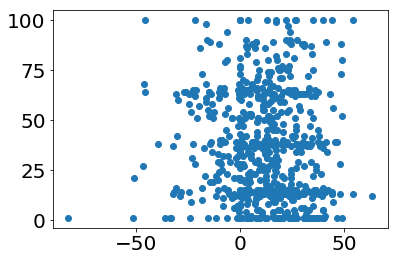

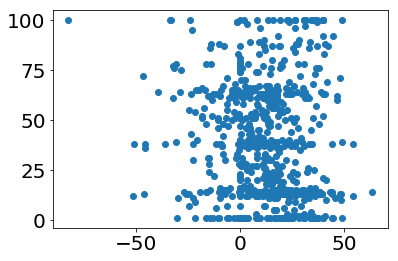

In [119]:
print(stats.pearsonr(np.ndarray.flatten(confirm),np.ndarray.flatten(fear_score)))
print(stats.pearsonr(np.ndarray.flatten(confirm),np.ndarray.flatten(hope_score)))
plt.scatter(np.ndarray.flatten(confirm),np.ndarray.flatten(fear_score))
plt.show()
plt.scatter(np.ndarray.flatten(confirm),np.ndarray.flatten(hope_score))

bias_emo=[]
non_bias_emo=[]
bias_rel=[]
non_bias_rel=[]
bias_fear=[]
non_bias_fear=[]
bias_hope=[]
non_bias_hope=[]
for i in bias_q:
    bias_emo.append(np.mean(emo_score,axis=0)[i])
    bias_rel.append(np.mean(rel_score,axis=0)[i])
    bias_fear.append(np.mean(fear_score,axis=0)[i])
    bias_hope.append(np.mean(hope_score,axis=0)[i])
for i in non_bias_q:
    non_bias_emo.append(np.mean(emo_score,axis=0)[i])
    non_bias_rel.append(np.mean(rel_score,axis=0)[i])
    non_bias_fear.append(np.mean(fear_score,axis=0)[i])
    non_bias_hope.append(np.mean(hope_score,axis=0)[i])

In [127]:
#calculate fear and hope scores for conf-biased and non-conf-biased questions
print(np.mean(bias_emo),np.mean(non_bias_emo))
print(np.std(bias_fear)*1.96/np.sqrt(len(bias_fear)))
print(np.mean(bias_rel),np.mean(non_bias_rel))
print(np.std(bias_hope)*1.96/np.sqrt(len(bias_hope)))
print(np.mean(bias_fear),np.mean(non_bias_fear))
print(np.mean(bias_hope),np.mean(non_bias_hope))

41.33181818181818 37.86363636363637
10.211198764344894
51.418181818181814 52.33471074380166
9.677671157603504
39.10454545454545 33.303719008264466
38.04090909090909 40.11363636363637


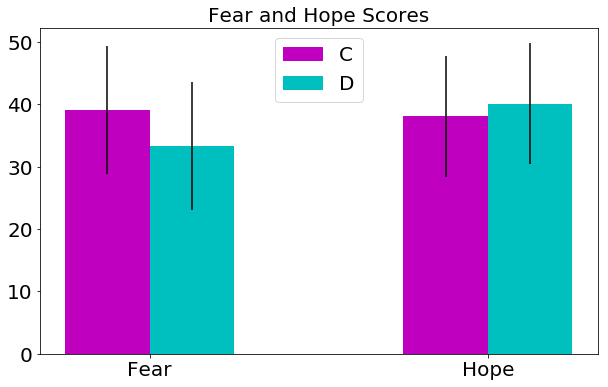

In [128]:
import numpy as np
from basic_units import cm, inch
import matplotlib.pyplot as plt


N = 2
biasMeans = (np.mean(bias_fear),np.mean(bias_hope))
biasStd = (1.96*np.std(bias_fear)/np.sqrt(len(bias_fear)), (1.96*np.std(bias_hope)/np.sqrt(len(bias_hope))))

fig, ax = plt.subplots(figsize=(10,6))
ind = np.arange(N)    # the x locations for the groups
width = 0.25         # the width of the bars
p1 = ax.bar(ind, biasMeans, width, color='m', bottom=0, yerr=biasStd)


unbiasMeans = (np.mean(non_bias_fear),np.mean(non_bias_hope))
unbiasStd = (1.96*np.std(bias_fear)/np.sqrt(len(bias_fear)), (1.96*np.std(bias_hope)/np.sqrt(len(bias_hope))))
p2 = ax.bar(ind + width, unbiasMeans, width,
            color='c', bottom=0, yerr=unbiasStd)

ax.set_title('Fear and Hope Scores')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Fear', 'Hope'))
ax.legend((p1[0], p2[0]), ('C', 'D'), loc=9)
#ax.yaxis.set_units(inch)
ax.autoscale_view()

plt.show()

In [129]:
#test for significant results
print(stats.ttest_ind(bias_fear,non_bias_fear))
print(stats.ttest_ind(bias_hope,non_bias_hope))
print(stats.ttest_ind(bias_emo,non_bias_emo))
print(stats.ttest_ind(bias_rel,non_bias_rel))

Ttest_indResult(statistic=0.9121149040345565, pvalue=0.3771473208106022)
Ttest_indResult(statistic=-0.33233237073440025, pvalue=0.744561836263429)
Ttest_indResult(statistic=0.7983893928154266, pvalue=0.4379789845402081)
Ttest_indResult(statistic=-0.16673734582765382, pvalue=0.8699609676426805)


In [130]:
#define high and low-trait groups.
high_opt=[]
low_opt=[]
for i in range(no_ind):
    if lotr_scores[i]>np.median(lotr_scores):
        high_opt.append(i)
    else:
        low_opt.append(i)
print(len(high_opt))

high_anx=[]
low_anx=[]
for i in range(no_ind):
    if gad_scores[i]>5:
        high_anx.append(i)
    else:
        low_anx.append(i)
print(len(high_anx))

high_pas=[]
low_pas=[]
for i in range(no_ind):
    if pas_scores[i]>np.median(pas_scores):
        high_pas.append(i)
    else:
        low_pas.append(i)
print(len(high_pas))

high_nas=[]
low_nas=[]
for i in range(no_ind):
    if nas_scores[i]>np.median(nas_scores):
        high_nas.append(i)
    else:
        low_nas.append(i)
print(len(high_nas))


21
14
19
19


In [153]:
#correlations with conservatism measures
print(stats.spearmanr(weight_evid,pas_scores))
print(stats.spearmanr(weight_evid,gad_scores))
print(stats.spearmanr(beta,lotr_scores))
print(stats.spearmanr(beta,nas_scores))
print(stats.spearmanr(beta,weight_evid))

SpearmanrResult(correlation=-0.07297113831608686, pvalue=0.6378338454030388)
SpearmanrResult(correlation=0.11081448276042519, pvalue=0.47392401852430177)
SpearmanrResult(correlation=0.15202864394722104, pvalue=0.32454828299270866)
SpearmanrResult(correlation=-0.08311441449954145, pvalue=0.591698269825384)
SpearmanrResult(correlation=0.7260042283298097, pvalue=2.448096728621897e-08)


In [154]:
print(stats.pearsonr(np.ndarray.flatten(fear_score),np.ndarray.flatten(hope_score)))
print(np.mean(fear_score,axis=0))

(-0.4073248323355741, 1.6244929726201694e-29)
[45.25       47.18181818 24.56818182 49.61363636 29.29545455 38.27272727
 34.68181818 52.81818182 34.81818182 20.13636364 22.95454545 16.97727273
 40.75       25.54545455 27.84090909 51.15909091]


In [155]:
np.mean(fear_score)

35.11647727272727

In [156]:
#function which returns mean bias for low and high-trait groups and t-test between two groups
def trait_compare(high,low,confirm_type):
    confirm_high=[]
    confirm_low=[]
    for i in high:
        confirm_high.append(confirm_type[i])
    for i in low:
        confirm_low.append(confirm_type[i])
    return [np.mean(confirm_high), 1.96*np.std(confirm_high)/np.sqrt(len(confirm_high)),
np.mean(confirm_low), 1.96*np.std(confirm_low)/np.sqrt(len(confirm_low)), stats.ttest_ind(confirm_high,confirm_low)]

In [157]:
#Do trait comparison for each of 4 trait measurements (interchange model type)
anx_arr=trait_compare(high_anx,low_anx,confirm_rl)
print(anx_arr[4])
opt_arr=trait_compare(high_opt,low_opt,confirm_rl)
print(opt_arr[4])
pas_arr=trait_compare(high_pas,low_pas,confirm_rl)
print(pas_arr[4])
nas_arr=trait_compare(high_nas,low_pas,confirm_rl)
print(nas_arr[4])

Ttest_indResult(statistic=-1.5916339612452675, pvalue=0.11896658146852077)
Ttest_indResult(statistic=0.3042822807740282, pvalue=0.7624154058079045)
Ttest_indResult(statistic=1.0726499946014127, pvalue=0.2895529358903498)
Ttest_indResult(statistic=0.025314115959813293, pvalue=0.9799243091378522)


In [158]:
low_fear=np.zeros((len(low_anx),16))
k=0
for i in low_anx:
    for j in range(16):
        low_fear[k][j]=(hope_score[i][j])
    k+=1
anx_fear=np.zeros((len(high_anx),16))
k=0
for i in high_anx:
    for j in range(16):
        anx_fear[k][j]=(hope_score[i][j])
    k+=1
print(np.mean(low_fear))
print(1.96*np.std(low_fear)/np.sqrt(len(low_fear)))
print(np.mean(anx_fear))
print(1.96*np.std(anx_fear)/np.sqrt(len(anx_fear)))

39.68958333333333
10.250110155223355
38.986607142857146
15.54531845223024


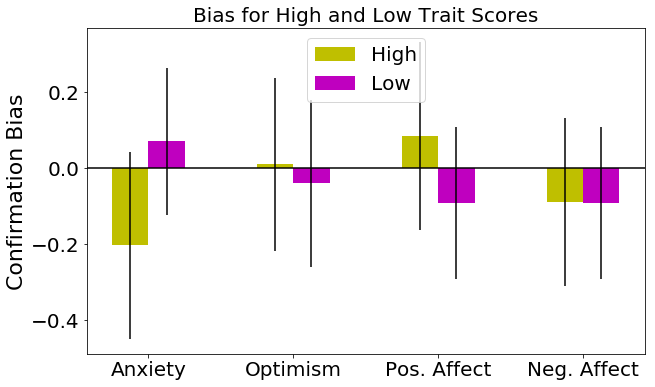

In [159]:
#Plot for trait comparison, adapted from matplotlib guide on bar plots.

import numpy as np
from basic_units import cm, inch
import matplotlib.pyplot as plt

N = 4
highMeans = (anx_arr[0],opt_arr[0],pas_arr[0],nas_arr[0])
highStd = (anx_arr[1],opt_arr[1],pas_arr[1],nas_arr[1])

fig, ax = plt.subplots(figsize=(10,6))
ind = np.arange(N)    # the x locations for the groups
width = 0.25         # the width of the bars
p1 = ax.bar(ind, highMeans, width, color='y', bottom=0, yerr=highStd)


lowMeans = (anx_arr[2],opt_arr[2],pas_arr[2],nas_arr[2])
lowStd = (anx_arr[3],opt_arr[3],pas_arr[3],nas_arr[3])
p2 = ax.bar(ind + width, lowMeans, width,
            color='m', bottom=0, yerr=lowStd)

ax.set_title('Bias for High and Low Trait Scores')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Anxiety', 'Optimism','Pos. Affect','Neg. Affect'))
ax.legend((p1[0], p2[0]), ('High', 'Low'), loc=9)
ax.axhline(color='k')
ax.set_ylabel('Confirmation Bias')
ax.autoscale_view()

plt.show()

In [161]:
#correlations with acquisition bias scores
acq_bias=np.zeros((no_ind,16))
for i in range(no_ind):
    for j in range(16):
        acq_bias[i][j]=no_blanc[i][j]-no_noir[i][j]
print(stats.spearmanr(np.mean(acq_bias,axis=1),gad_scores))
print(stats.spearmanr(np.mean(acq_bias,axis=1),lotr_scores))
print(stats.spearmanr(np.mean(acq_bias,axis=1),pas_scores))
print(stats.spearmanr(np.mean(confirm,axis=1),nas_scores))

SpearmanrResult(correlation=-0.06801128821917152, pvalue=0.660910138449226)
SpearmanrResult(correlation=0.0891384272403158, pvalue=0.5650188242849564)
SpearmanrResult(correlation=0.19363728355672977, pvalue=0.20787593741002272)
SpearmanrResult(correlation=-0.2425888642193631, pvalue=0.11259634376458175)


In [162]:
print(stats.pearsonr(p_update,gad_scores))
print(stats.pearsonr(p_update,lotr_scores))
print(stats.pearsonr(p_update,pas_scores))
print(stats.pearsonr(p_update,nas_scores))

(-0.058205855797567485, 0.7074392833414026)
(0.04549635174247324, 0.7693291387700671)
(-0.18951808993073976, 0.21789924047276346)
(0.0316590347433983, 0.8383474818282391)


In [163]:
print(stats.pearsonr(np.mean(abs(50-before),axis=1),gad_scores))
print(stats.pearsonr(np.mean(abs(50-before),axis=1),lotr_scores))
print(stats.pearsonr(np.mean(abs(50-before),axis=1),pas_scores))
print(stats.pearsonr(np.mean(abs(50-before),axis=1),nas_scores))

(-0.08418895859527342, 0.5868986215520324)
(0.0005149313680557157, 0.9973531553913699)
(-0.11356432421430528, 0.462952513511964)
(-0.14289309959494353, 0.35479991525623)


In [164]:
print(stats.pearsonr(np.mean(abs(50-before),axis=1),new_confirm))
print(stats.pearsonr(np.mean(abs(50-before),axis=1),np.mean(confirm,axis=1)))
print(stats.pearsonr(np.mean(abs(50-before),axis=1),pas_scores))
print(stats.pearsonr(np.mean(abs(50-before),axis=1),nas_scores))

(0.23622474877693578, 0.12264446554174971)
(0.4639663803209498, 0.001512646313698306)
(-0.11356432421430528, 0.462952513511964)
(-0.14289309959494353, 0.35479991525623)


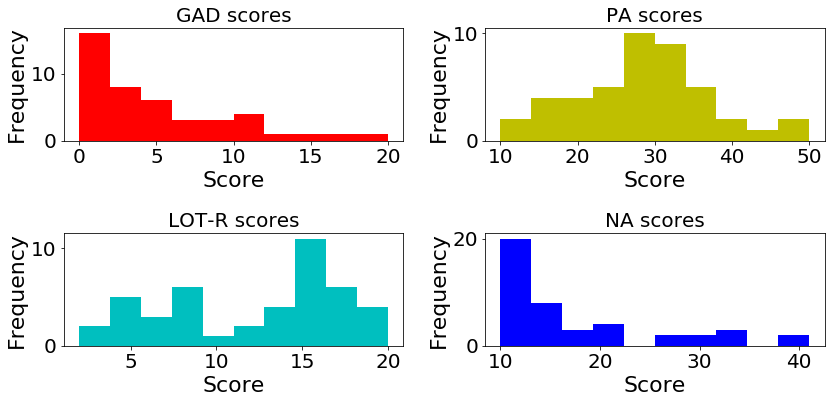

In [166]:
#Distribution of scores for personality questionnaires
plt.figure(figsize=(14,6))
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].set_title('GAD scores')
axes[0,0].set_xlabel('Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].hist(gad_scores,color='r')
axes[0, 1].set_title('PA scores')
axes[0,1].hist(pas_scores,color='y')
axes[0,1].set_xlabel('Score')
axes[0,1].set_ylabel('Frequency')
axes[1, 0].set_title('LOT-R scores')
axes[1,0].hist(lotr_scores,color='c')
axes[1,0].set_xlabel('Score')
axes[1,0].set_ylabel('Frequency')
axes[1,1].set_title('NA scores')
axes[1,1].hist(nas_scores,color='b')
axes[1,1].set_xlabel('Score')
axes[1,1].set_ylabel('Frequency')
fig.set_figheight(6)
fig.set_figwidth(12)
fig.tight_layout()